## Importar librerías

In [4]:
!pip install -U gdown pydrive

In [5]:
import cv2
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Carga de archivos

In [6]:
# Definir rutas y nombres
train_dataset_name = "GPTeam-DeepLearning/Dataset/bcn_20k_train"  # Nombre de la carpeta de imágenes
test_dataset_name = "GPTeam-DeepLearning/Dataset/bcn_20k_test"  # Nombre de la carpeta de imágenes
drive_mount_path = "/content/drive"
drive_train_dataset_path = f"{drive_mount_path}/My Drive/{train_dataset_name}"  # Ruta en Drive
drive_test_dataset_path = f"{drive_mount_path}/My Drive/{test_dataset_name}"  # Ruta en Drive
train_folder_id = "1PPUxdAGNTM3Be1zbfzUUlY6xUelNZhM5"  # ID de la carpeta con data de entrenamiento en Google Drive compartido
test_folder_id = "1a_Y7zY5wRwrRfOC2XnEGW9zrFFtgbIxF"  # ID de la carpeta con data de entrenamiento en Google Drive compartido

# CARGA DEL DATASET DE ENTRENAMIENTO
# Verificar si Google Drive ya está montado
if not os.path.exists(drive_mount_path):
    print("Montando Google Drive...")
    drive.mount(drive_mount_path)
else:
    print("Google Drive ya está montado.")

# CARGA DEL DATASET DE ENTRENAMIENTO
print("Carga de archivos de entrenamiento")
# Verificar si la carpeta ya existe en Google Drive
if os.path.exists(drive_train_dataset_path):
    print(f"Dataset encontrado en Google Drive: {drive_train_dataset_path}")
    dataset_train_path = drive_train_dataset_path
else:
    print("Dataset no encontrado en Google Drive. Procediendo con la descarga...")
    # Instalar gdown y descargar el dataset desde Drive
    !pip install -U gdown
    !gdown --folder --id {train_folder_id} --remaining-ok -O "{drive_train_dataset_path}"
    dataset_train_path = drive_train_dataset_path
print(f"Dataset disponible en: {dataset_train_path}")

# CARGA DEL DATASET DE PRUEBA
print("Carga de archivos de prueba")
# Verificar si la carpeta ya existe en Google Drive
if os.path.exists(drive_test_dataset_path):
    print(f"Dataset encontrado en Google Drive: {drive_test_dataset_path}")
    dataset_test_path = drive_test_dataset_path
else:
    print("Dataset no encontrado en Google Drive. Procediendo con la descarga...")
    # Instalar gdown y descargar el dataset desde Drive
    !pip install -U gdown
    !gdown --folder --id {test_folder_id} --remaining-ok -O "{drive_test_dataset_path}"
    dataset_test_path = drive_test_dataset_path
print(f"Dataset disponible en: {dataset_test_path}")



Montando Google Drive...
Mounted at /content/drive
Carga de archivos de entrenamiento
Dataset encontrado en Google Drive: /content/drive/My Drive/GPTeam-DeepLearning/Dataset/bcn_20k_train
Dataset disponible en: /content/drive/My Drive/GPTeam-DeepLearning/Dataset/bcn_20k_train
Carga de archivos de prueba
Dataset encontrado en Google Drive: /content/drive/My Drive/GPTeam-DeepLearning/Dataset/bcn_20k_test
Dataset disponible en: /content/drive/My Drive/GPTeam-DeepLearning/Dataset/bcn_20k_test


## Mostrar imagenes

In [7]:
def mostrar_grilla_imagenes(directorio, columnas=5, n_imagenes=25):
    # Obtener la lista de imágenes en el directorio
    imagenes = [f for f in os.listdir(directorio) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    imagenes = imagenes[:n_imagenes]  # Tomar solo las primeras n imágenes disponibles

    if not imagenes:
        print("No se encontraron imágenes en el directorio.")
        return

    # Calcular filas necesarias
    filas = math.ceil(len(imagenes) / columnas)  # Redondeo hacia arriba

    # Obtener el nombre del directorio para la cabecera
    nombre_directorio = os.path.basename(directorio)

    # Crear la figura con el tamaño ajustado
    fig, axes = plt.subplots(filas, columnas, figsize=(columnas * 2, filas * 2))
    fig.suptitle(f"📂 {nombre_directorio}", fontsize=16, fontweight='bold', y=1.05)  # Cabecera
    axes = axes.flatten()  # Convertir la matriz de ejes en lista

    # Mostrar imágenes en la grilla
    for i, ax in enumerate(axes):
        if i < len(imagenes):
            img_path = os.path.join(directorio, imagenes[i])
            img = cv2.imread(img_path)  # Cargar imagen
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
            ax.imshow(img)
            ax.set_title(imagenes[i], fontsize=8)  # Nombre del archivo
        ax.axis("off")  # Ocultar ejes

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

<ipython-input-7-a0be058f70fb>:32: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


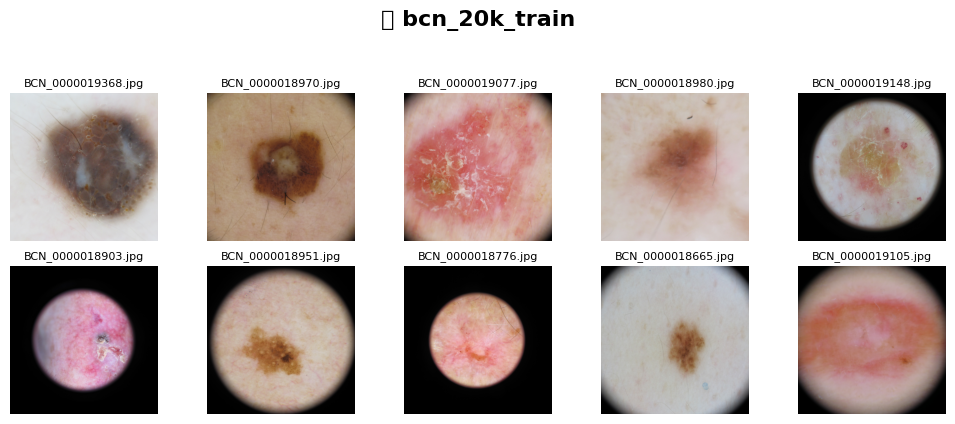

In [8]:
mostrar_grilla_imagenes(dataset_train_path, columnas=5, n_imagenes=10)

In [9]:
def plotHorizontalBar(df, columnName, xlabelName, ylabelName, title):

  diagnosis_counts = df[columnName].value_counts()
  # Crear el gráfico de barras
  plt.figure(figsize=(10, 6))
  diagnosis_counts.plot(kind='bar', color='skyblue', edgecolor='black')
  ax = diagnosis_counts.plot(kind='bar', color='skyblue', edgecolor='black')

    # Añadir las etiquetas de cantidad sobre cada barra
  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')

  # Configurar etiquetas y título
  plt.xlabel(xlabelName)
  plt.ylabel(ylabelName)
  plt.title(title)
  plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

  # Mostrar el gráfico
  plt.show()

# Visualizacion de valores de diagnostico del dataset

In [10]:
dataset_address_descripcion_csv = "GPTeam-DeepLearning/Dataset/bcn_20k_train.csv"
drive_dataset_metadata_path = f"{drive_mount_path}/My Drive/{dataset_address_descripcion_csv}"
df = pd.read_csv(drive_dataset_metadata_path)

## Verificación de que todos los archivos han sido cargados

In [11]:
archivos_en_drive = []
# Recorrer todos los archivos en el directorio
for archivo in os.listdir(dataset_train_path):
    if os.path.isfile(os.path.join(dataset_train_path, archivo)):
        archivos_en_drive.append(archivo)

# La columna del DataFrame con los nombres de los archivos
column_files = df['bcn_filename']
# Convertir las listas a conjuntos para realizar la diferencia
set_column_files = set(column_files)
set_archivos_en_drive = set(archivos_en_drive)
valores_faltantes = set_column_files - set_archivos_en_drive
# Encontrar los archivos que están en 'df["bcn_filename"]' pero no en 'archivos_en_drive'

with open("Faltantes.txt", 'w') as archivo:
    for valor in valores_faltantes:
        archivo.write(valor + '\n')

## Filtro de filas con clases poco representativas

In [12]:
# Sustraccion de diagnosticos con menor cantidad de datos
diagnosticos_a_desestimar = ['SCC', 'DF', 'VASC']

# Filtrar el DataFrame para eliminar las filas con los valores especificados en la columna 'diagnosis'
df = df[~df['diagnosis'].isin(diagnosticos_a_desestimar)]

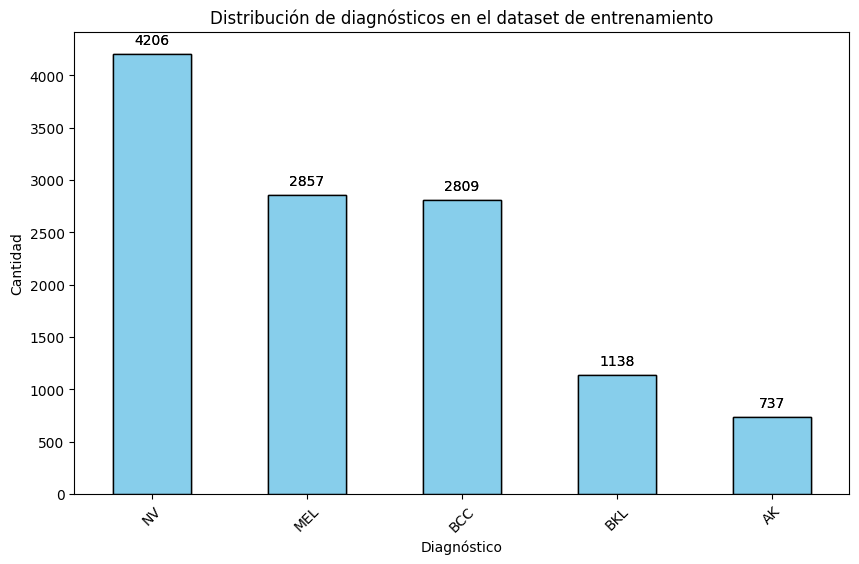

In [13]:
plotHorizontalBar(df, 'diagnosis', 'Diagnóstico', 'Cantidad', 'Distribución de diagnósticos en el dataset de entrenamiento')

# Preparación del dataset

In [14]:
# Obtener los valores únicos de lesion_id
unique_lesions = df['lesion_id'].unique()

# Búsqueda del mejor split
best_train, best_test = None, None
target_ratio = 0.8 * len(df)

for seed in range(1000):  # Exploramos diferentes random_state
    train_ids, test_ids = train_test_split(unique_lesions, test_size=0.2, random_state=seed)

    x_train = df[df['lesion_id'].isin(train_ids)]
    x_test = df[df['lesion_id'].isin(test_ids)]

    # Verificar que la cantidad de filas sea la correcta Y que los lesion_id no se repitan
    if abs(len(x_train) - target_ratio) < 1 and set(x_train['lesion_id']).isdisjoint(set(x_test['lesion_id'])):
        best_train, best_test = x_train, x_test
        print(f"Random state encontrado: {seed}")
        break

# Si no se encontró un split válido, lanzar error
if best_train is None or best_test is None:
    raise ValueError("No se encontró un split válido después de 1000 intentos")

# Asignar los mejores valores encontrados
x_train, x_test = best_train, best_test

assert set(x_train['lesion_id']).isdisjoint(set(x_test['lesion_id'])), "Error: Hay lesion_id repetidos entre x_train y x_test"

Random state encontrado: 25


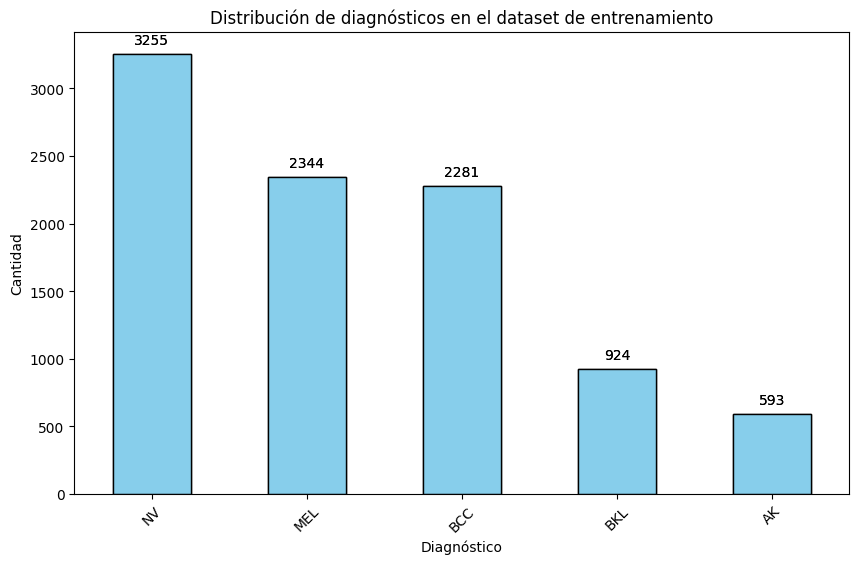

In [15]:
plotHorizontalBar(x_train, 'diagnosis', 'Diagnóstico', 'Cantidad', 'Distribución de diagnósticos en el dataset de entrenamiento')

# Pre-procesamiento de las imágenes

In [16]:
def get_training_transforms(crop_size=(64, 64)):
    transform = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    return transform

def get_eval_transforms(crop_size=(64, 64)):
    transform = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    return transform


# Definición del dataset

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, df, drive_dataset_metadata_path, transform=None):
        # Filtrar filas válidas (cuyos archivos existan)
        valid_indices = []
        for idx, row in df.iterrows():
            filename = row['bcn_filename']
            image_path = os.path.join(drive_dataset_metadata_path, filename)
            if os.path.exists(image_path):
                valid_indices.append(idx)
        if not valid_indices:
            raise ValueError("No se encontraron imágenes válidas en la ruta especificada.")

        self.df = df.loc[valid_indices].reset_index(drop=True)
        self.drive_dataset_metadata_path = drive_dataset_metadata_path
        self.transform = transform if transform is not None else get_eval_transforms()

        # Crear un diccionario mapeando 'bcn_filename' a la etiqueta (usando la columna 'diagnosis')
        if 'diagnosis' in self.df.columns:
            mapping_temp = {row['bcn_filename']: row['diagnosis'] for _, row in self.df.iterrows()}
            unique_labels = sorted(set(mapping_temp.values()))
            label_to_int = {label: i for i, label in enumerate(unique_labels)}
            self.label_map = {fname: label_to_int[label] for fname, label in mapping_temp.items()}
        else:
            self.label_map = None

        # Pre-cargar y convertir a tensor todas las imágenes y etiquetas
        self.images = []
        self.labels = []  # Sólo se usará si self.label_map no es None
        for _, row in self.df.iterrows():
            filename = row['bcn_filename']
            image_path = os.path.join(self.drive_dataset_metadata_path, filename)
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            self.images.append(image)

            if self.label_map is not None:
                label = self.label_map[filename]
                # Convertir la etiqueta a tensor
                label = torch.tensor(label, dtype=torch.long)
                self.labels.append(label)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Devuelve el tensor de la imagen precargada y, si existe, su etiqueta
        image = self.images[idx]
        if self.label_map is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image
def create_dataloader(df, drive_dataset_metadata_path, batch_size=64, shuffle=True, transform=None):
    dataset = CustomImageDataset(df, drive_dataset_metadata_path, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


# Definición de los modelos Transformer y CNN

In [18]:
class TransformerModule(nn.Module):
    """
    Módulo transformer para procesar secuencias, usando batch_first.
    """
    def __init__(self, seq_length, d_model=256, nhead=8, num_layers=2, dropout=0.5):
        super(TransformerModule, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, seq_length, d_model)
        x = x + self.pos_embedding.unsqueeze(0)
        x = self.transformer_encoder(x)  # Ahora sin necesidad de transponer
        x = x.mean(dim=1)
        x = self.dropout(x)
        return x

class CNNTransformerClassifier(nn.Module):
    """
    Modelo híbrido que integra una CNN de 4 capas (divididas en 2 bloques con pooling)
    con un módulo Transformer. La salida final es una clasificación en 5 clases.
    Se aplican BatchNorm, Dropout y se inicializan pesos con Kaiming.
    """
    def __init__(self, num_classes=5, dropout=0.5):
        super(CNNTransformerClassifier, self).__init__()
        # Bloque 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32

        # Bloque 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16

        # Datos para el transformer
        self.feature_map_size = 16  # luego de pool2 (16x16)
        self.seq_length = self.feature_map_size * self.feature_map_size  # 256 tokens
        self.d_model = 256  # dimensión de cada token

        # Módulo Transformer
        self.transformer = TransformerModule(seq_length=self.seq_length, d_model=self.d_model, nhead=8, num_layers=2, dropout=dropout)

        # Capa final para clasificación
        self.fc = nn.Linear(self.d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Bloque 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        # Bloque 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)  # x: (B, 256, 16, 16)

        B, C, H, W = x.size()
        # Reorganizar para formar secuencia: (B, tokens, d_model)
        x = x.view(B, C, -1)    # (B, 256, 256)
        x = x.transpose(1, 2)   # (B, 256, 256)

        # Procesar con el Transformer
        x = self.transformer(x)  # (B, d_model)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits


## Funciones de entrenamiento y evaluación

In [19]:
def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                inputs, labels = batch
                # Si las etiquetas vienen como strings, convierto cada una a entero
                if isinstance(labels, (list, tuple)) and isinstance(labels[0], str):
                    labels = [int(l) for l in labels]
                if not isinstance(inputs, torch.Tensor):
                    inputs = torch.stack(inputs)
                if not isinstance(labels, torch.Tensor):
                    labels = torch.tensor(labels)
                inputs, labels = inputs.to(device), labels.to(device)
            else:
                continue
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if total == 0:
        logging.warning("No se procesaron muestras en evaluación. Retornando loss=0 y accuracy=0.")
        return 0.0, 0.0
    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5, eval_loader=None, writer=None):
    model.to(device)
    total_samples = len(dataloader.dataset)
    total_batches = len(dataloader)


    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        processed_samples = 0

        for batch_idx, batch in enumerate(dataloader, start=1):
            print(type(batch))
            if isinstance(batch, torch.Tensor):
                inputs, labels = batch
            else:
              continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            running_total += labels.size(0)
            processed_samples += batch_size

            # Loguea el progreso por batch usando logging
            print(f"Epoch {epoch}/{num_epochs} - Batch {batch_idx}/{total_batches} - Procesados {processed_samples}/{total_samples} muestras")

            if writer is not None:
                global_step = (epoch - 1) * total_batches + batch_idx
                writer.add_scalar('Train/Batch_Loss', loss.item(), global_step)

        epoch_loss = running_loss / running_total if running_total > 0 else 0.0
        epoch_accuracy = running_correct / running_total if running_total > 0 else 0.0

        logging.info(f"Epoch {epoch}/{num_epochs} completada. Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy * 100:.2f}%")

        if eval_loader is not None:
            eval_loss, eval_accuracy = evaluate_model(model, eval_loader, device, criterion)
            logging.info(f"    Eval - Loss: {eval_loss:.4f} | Accuracy: {eval_accuracy * 100:.2f}%")
            if writer is not None:
                writer.add_scalar('Eval/Loss', eval_loss, epoch)
                writer.add_scalar('Eval/Accuracy', eval_accuracy, epoch)

        if writer is not None:
            writer.add_scalar('Train/Epoch_Loss', epoch_loss, epoch)
            writer.add_scalar('Train/Epoch_Accuracy', epoch_accuracy, epoch)


## Ejecución del modelo: Carga de datos

In [26]:
# Ruta a la carpeta con las imágenes
drive_dataset_metadata_path = dataset_train_path
batch_size = 64
num_epochs = 1
learning_rate = 0.01

train_transform = get_training_transforms(crop_size=(32, 32))
test_transform  = get_eval_transforms(crop_size=(32, 32))

train_loader = create_dataloader(x_train, drive_dataset_metadata_path, batch_size=batch_size, shuffle=True, transform=train_transform)
test_loader = create_dataloader(x_test, drive_dataset_metadata_path, batch_size=batch_size, shuffle=False, transform=test_transform)

KeyboardInterrupt: 

## Ejecucion del modelo: Entrenamiento del modelo

In [ ]:
model = CNNTransformerClassifier(num_classes=5, dropout=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Entrenando en: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter(log_dir='./runs/experiment_1')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=num_epochs, eval_loader=test_loader, writer=writer)

## Ejecución del modelo: Prueba del modelo

In [ ]:
final_loss, final_accuracy = evaluate_model(model, test_loader, device, criterion)
logging.info(f"Evaluación final en validación - Loss: {final_loss:.4f} | Accuracy: {final_accuracy*100:.2f}%")

writer.close()

In [27]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)

NameError: name 'train_loader' is not defined